# Part 2: Building a simple chess playing model

In [1]:
import random
import chess

def play_random(fen):
    board = chess.Board(fen=fen)
    move = random.choice(list(board.legal_moves))
    return str(move)

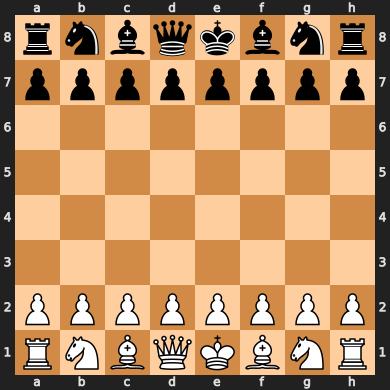

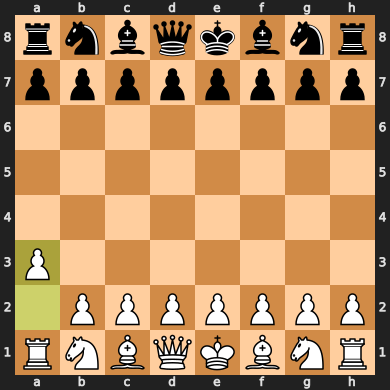

AI move: b8c6


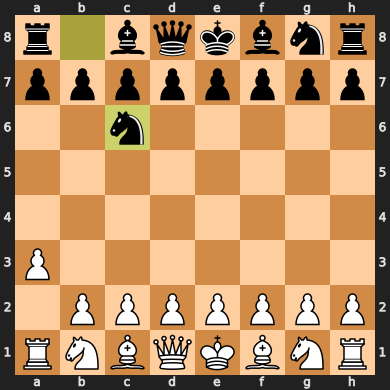

That wasn't a valid move. Please enter a move in Standard Algebraic Notation
That wasn't a valid move. Please enter a move in Standard Algebraic Notation
That wasn't a valid move. Please enter a move in Standard Algebraic Notation
That wasn't a valid move. Please enter a move in Standard Algebraic Notation
That wasn't a valid move. Please enter a move in Standard Algebraic Notation
That wasn't a valid move. Please enter a move in Standard Algebraic Notation
That wasn't a valid move. Please enter a move in Standard Algebraic Notation
That wasn't a valid move. Please enter a move in Standard Algebraic Notation
That wasn't a valid move. Please enter a move in Standard Algebraic Notation
That wasn't a valid move. Please enter a move in Standard Algebraic Notation
That wasn't a valid move. Please enter a move in Standard Algebraic Notation
That wasn't a valid move. Please enter a move in Standard Algebraic Notation
That wasn't a valid move. Please enter a move in Standard Algebraic Notation

KeyboardInterrupt: Interrupted by user

In [2]:
from IPython.display import SVG, display

def play_game(ai_function):
    board = chess.Board()

    while board.outcome() is None:
        display(SVG(board._repr_svg_()))

        if board.turn == chess.WHITE:
            user_move = input('Your move: ')
            if user_move == 'quit':
                break
            while user_move not in [str(move) for move in board.legal_moves]:
                print('That wasn\'t a valid move. Please enter a move in Standard Algebraic Notation')
                user_move = input('Your move: ')
            board.push_san(user_move)

        elif board.turn == chess.BLACK:
            ai_move = ai_function(board.fen())
            print(f'AI move: {ai_move}')
            board.push_san(ai_move)
    print(board.outcome())
        
play_game(play_random)

That's fun, but we should level up our game!
There are two ways we can think about building our model that come from Reinforcement Learning:

1. A Policy
2. A Value Function

In RL a policy is a function that goes from "world states" (everything our AI knows about the world) to actions. It's a pretty natural fit for chess, where our "world state" is our FEN string (the board) and actions are the legal chess moves our AI could make.

There's one catch: while our world state is relatively simple, there are a lot of potential moves our model needs to be able to put out. There are 64 possible starting square and 64 possible ending squares--so that's technically 64^2 = 4096 possible moves.

Whats more, on any given turn, most of those 4096 possible turns won't even be legal moves, so our model will have to try real hard just to output a move it's allowed to make. But we already know what moves are legal, python-chess gives that to us for free!

So another way we can think about this is to implement a `value function`. A value function basically just tells our AI how good a certain state of the world is.

For example, a board where we have all our pieces, and our opponent only has a king and 1 pawn is great for us, and our value function would put out a really high number. If this was reversed, we'd be doing terribly, and our value function would put out a really low number.

So instead of training our model to take in the board state and output a move (this would be treating our model as a policy) we could train our model to take in the board state and output a value (treating our model as a value function). Then we can just loop through all possible moves, rate all the possible board states after making those moves, and then pick the move with the highest board state.

# Preparing our Data
Before we feed our input into a neural network for training, we need to turn it all into numbers.

Once we replace the numbers with periods, our FEN notation is pretty close--it's an 8x8 grid of characters.

```
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
```

One commone strategy in machine learning is to _one hot encode_ our input. There are 13 different characters on our board right now: 6 upper case (white) pieces, 6 lower case (black) pieces, and . for empty spaces. So we could one-hot encode our input with a list of 13 elements, one for each piece type:

This could be the one hot encoding for a white Bishop:

```
 r n b q k p R N B Q K P .
[0 0 0 0 0 0 0 0 1 0 0 0 0]
```

And this could be the one hot encoding for an empty space:
```
 r n b q k p R N B Q K P .
[0 0 0 0 0 0 0 0 0 0 0 0 1]
```

Notice in both examples we only have 1 1, and all the rest are zeros.

In [ ]:
import numpy as np

def one_hot_encode_peice(piece):
    pieces = list('rnbqkpRNBQKP.')
    arr = np.zeros(len(pieces))
    piece_to_index = {p: i for i, p in enumerate(pieces)}
    index = piece_to_index[piece]
    arr[index] = 1
    return arr

one_hot_encode_peice('b')

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
def encode_board(board):
    board_str = str(board)
    board_str = board_str.replace(' ', '')
    board_list = []
    for row in board_str.split('\n'):
        row_list = []
        for piece in row:
            row_list.append(one_hot_encode_peice(piece))
        board_list.append(row_list)
    return np.array(board_list)

encode_board(chess.Board())

array([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

    

In [ ]:
import pandas as pd

train_df = pd.read_csv('/kaggle/input/train-an-ai-to-play-chess/train.csv', index_col='id')

train_df = train_df[:10000]

val_df = train_df[-1000:]
train_df.head()

,board,black_score,best_move
id,,,
80091,6R1/8/5K2/8/5k2/8/8/2r5 w - - 89 118,0.0,g8d8
18578,r1bn1rk1/1p2b1p1/1q2p2p/p2p1p1n/P2P3P/2PB1N2/1...,-131.0,f3e5
11580,r2qkb1r/2p2pp1/p1n2nP1/1p1p3p/P7/1Q5b/1PP1PPB1...,-490.0,g6f7
72805,8/4kp2/R6p/8/4K3/8/8/8 b - - 7 85,-574.0,h6h5
74310,8/8/k7/4R3/8/6K1/8/1r6 w - - 99 90,0.0,e5e6


In [ ]:
import numpy as np
def encode_fen_string(fen_str):
    board = chess.Board(fen=fen_str)
    return encode_board(board)

X_train = np.stack(train_df['board'].apply(encode_fen_string))
y_train = train_df['black_score']


X_val = np.stack(val_df['board'].apply(encode_fen_string))
y_val = val_df['black_score']

# Building Our Model

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPool2D

model = Sequential([
    Flatten(),
    Dense(128, activation='relu'),
    MaxPool2D(),
    Dense(1),
])

model.compile(
    optimizer='rmsprop',
    loss='mean_squared_error')

I0000 00:00:1740377674.106657   33973 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5911 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_val, y_val))

Epoch 1/20
313/313 [==============================] - 2s 4ms/step - loss: 154100.3906 - val_loss: 140516.8438
Epoch 2/20
313/313 [==============================] - 1s 4ms/step - loss: 150773.5625 - val_loss: 136599.1562
Epoch 3/20
313/313 [==============================] - 1s 4ms/step - loss: 145985.4531 - val_loss: 132122.0312
Epoch 4/20
313/313 [==============================] - 1s 4ms/step - loss: 141229.7188 - val_loss: 127980.5625
Epoch 5/20
313/313 [==============================] - 1s 4ms/step - loss: 137281.1094 - val_loss: 124720.1172
Epoch 6/20
313/313 [==============================] - 1s 4ms/step - loss: 134046.3906 - val_loss: 122247.8281
Epoch 7/20
313/313 [==============================] - 1s 4ms/step - loss: 131216.7500 - val_loss: 120143.9766
Epoch 8/20
313/313 [==============================] - 1s 4ms/step - loss: 128608.2266 - val_loss: 118561.5781
Epoch 9/20
313/313 [==============================] - 1s 4ms/step - loss: 126414.6719 - val_loss: 116544.8984
Epoch 10/2

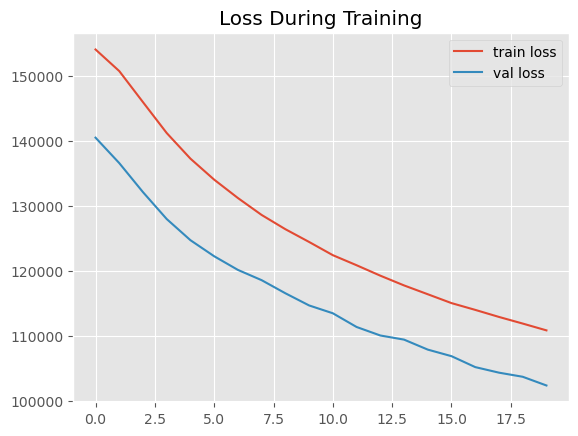

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss During Training')
plt.show()

# Using our Value Function to create a Policy

So we have a decent value function now! We show it a board state, and it tells us how good that board is for black.

But if our AI is going to play chess, we need a way to turn that board state into a decision, or in other words, we need to use our value function to create a policy.

One simple way we can do this is to look at all the legal moves we can make, test our making each of them, and pick whatever move gives us the highest value to the resultant board state. Let's code that up!

In [ ]:
def play_nn(fen, show_move_evaluations=False, player='b'):
    board = chess.Board(fen=fen)

    moves = []
    for move in board.legal_moves:
        candidate_board = board.copy()
        candidate_board.push(move)
        input_vector = encode_board(str(candidate_board)).astype(np.int32).flatten()
        
        score = model.predict(np.expand_dims(input_vector, axis=0), verbose=0)[0][0]
        moves.append((score, move))
        if show_move_evaluations:
            print(f'{move}: {score}')
    best_move = sorted(moves, reverse=player=='b')[0][1]

    return str(best_move)

In [ ]:
play_game(play_nn)